## Your turn!
Choose a different model.
  - Any [huggingface models](https://huggingface.co/models).

See if you can find a model that returns a score with a relationship for
  - Our readability corpus
    - readability
    - domain
    - text type (simplified or authentic)
  - Our writing quality corpus
    - writing quality
    - grammar/mechanics

Make sure you do the following
1. Develop good research questions
2. Have solid hypotheses
3. Check the model card and make sure the model is reliable (or at least well documented)

**Example**

This is a model trained on a readability scores that are similar to the readability scores reported in our 2019 dataset of ~600 excerpts.

Trained on a much larger dataset (n = ~5,000 excerpts)
  - No overlap between excerpts

## Research Question
To what extent do the predicted readability scores from the huggingface model correlate with the original readability scores in our corpus?


## Hypothesis
There is a significant positive correlation between the predicted readability scores from the Hugging Face model and the original readability scores assigned in the dataset.

Here I choose two models:
*   https://huggingface.co/agentlans/mdeberta-v3-base-readability
*   https://huggingface.co/v-urushkin/xlm-roberta-base-readability -- A model for contest https://www.kaggle.com/competitions/commonlitreadabilityprize

## The first model

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from scipy.stats import ttest_ind, spearmanr
import torch
import torch.nn as nn
from transformers import AutoModel
from huggingface_hub import PyTorchModelHubMixin

In [69]:
from google.colab import drive
import pandas as pd
# Below will prompt for authorization
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
df_read = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/DS_5780_spring_25/reading_600_texts.csv",
    encoding='ISO-8859-1'
    )

df_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              591 non-null    int64  
 1   text            591 non-null    object 
 2   bt_readability  591 non-null    float64
 3   Source          588 non-null    object 
 4   Topic           591 non-null    object 
 5   Text type       591 non-null    object 
 6   Domain          591 non-null    object 
 7                   0 non-null      float64
dtypes: float64(2), int64(1), object(5)
memory usage: 37.1+ KB


In [71]:
model_name = "agentlans/deberta-v3-base-readability-v2"
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [72]:
readability_pipe = pipeline("text-classification", model=model_name, tokenizer=model_name)

result = readability_pipe("I hate this style.")
print(result)


Device set to use cuda:0


[{'label': 'LABEL_0', 'score': 0.8889616131782532}]


In [73]:
readability_pipe.model.config

DebertaV2Config {
  "_attn_implementation_autoset": true,
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-07,
  "legacy": true,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "torch_dtype": "float32",
  "transformers_version": "4.50.3",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

In [74]:
results_hw = readability_pipe(list(df_read['text']))

In [75]:
df_read['readability'] = [x['score'] for x in results_hw]
# Extracts value associated with score for each text and assigns to df

In [76]:
df_read

,id,text,bt_readability,Source,Topic,Text type,Domain,,readability
0,1,The Solar System is the Sun and all the object...,0.022084,https://simple.wikipedia.org/wiki/Solar_System,solar system,Simple,Science,NaN,0.991920
1,2,An atom is the basic unit that makes up all ma...,0.117281,https://simple.wikipedia.org/wiki/Atom,atom,Simple,Science,NaN,0.998267
2,3,An ion is an electrically charged atom or grou...,0.170116,https://simple.wikipedia.org/wiki/Ion,ion,Simple,Science,NaN,0.999670
3,4,Plasma is a state of matter. The three other c...,0.393468,https://simple.wikipedia.org/wiki/Plasma_(phys...,plasma,Simple,Science,NaN,0.999613
4,5,The South Pole is the most southern point on t...,0.007675,https://simple.wikipedia.org/wiki/South_Pole,South Pole,Simple,Science,NaN,0.999154
...,...,...,...,...,...,...,...,...,...
586,596,Historiography is the study of the methodology...,0.181519,https://en.wikipedia.org/wiki/Historiography,Historiography,Regular,History,NaN,1.000000
587,597,Post-classical history (also called the Post-A...,0.240442,https://en.wikipedia.org/wiki/Post-classical_h...,post-classical history,Regular,History,NaN,1.000000
588,598,Oracle bone script (Chinese: ç²éª¨æ) was th...,0.814657,https://en.wikipedia.org/wiki/Oracle_bone_script,oracle bone script,Regular,History,NaN,1.000000
589,599,A water clock or clepsydra (Greek ÎºÎ»ÎµÏÏÎ´...,0.054526,https://en.wikipedia.org/wiki/Water_clock,water clock,Regular,History,NaN,0.999998


SignificanceResult(statistic=np.float64(0.3739275460072117), pvalue=np.float64(4.740162089216761e-21))


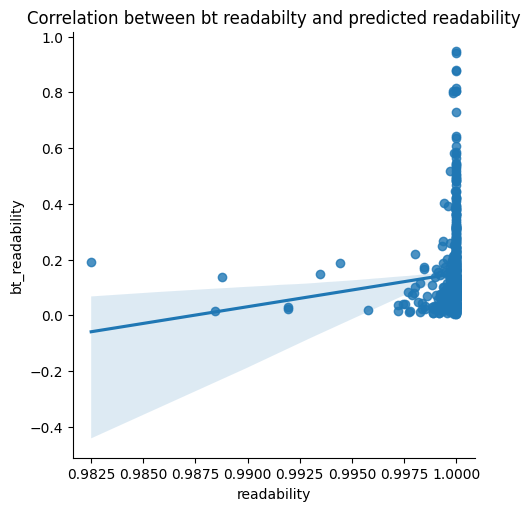

In [77]:
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

print(spearmanr(df_read['readability'], df_read['bt_readability']))

sns.lmplot(df_read, x='readability', y='bt_readability')
plt.title('Correlation between bt readabilty and predicted readability')
plt.savefig("readability_boxplot.png", dpi=300, bbox_inches='tight')

plt.show()


### Findings for the first model
The first model applied in this study returned predicted readability scores that were highly concentrated around the upper bound (values close to 1.0). These scores likely represent normalized outputs or probabilities, rather than interpretable readability levels such as U.S. grade levels.

While the model may still serve basic binary classification use cases (e.g., simple vs. complex), it is not well-suited for fine-grained readability analysis in an educational or research context. A switch to a model that outputs continuous grade-level scores is warranted for further exploration.

## The Second model

In [78]:
model_name = "v-urushkin/xlm-roberta-base-readability"
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [79]:
readability_pipe = pipeline("text-classification", model=model_name, tokenizer=model_name)

result = readability_pipe("I hate this style.")
print(result)


Device set to use cuda:0


[{'label': 'LABEL_0', 'score': -0.1486707478761673}]


In [80]:
readability_pipe.model.config

XLMRobertaConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "XLMRobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "regression",
  "torch_dtype": "float32",
  "transformers_version": "4.50.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [81]:
results_hw = readability_pipe(list(df_read['text']))

In [82]:
df_read['readability'] = [x['score'] for x in results_hw]
# Extracts value associated with score for each text and assigns to df

In [83]:
df_read

,id,text,bt_readability,Source,Topic,Text type,Domain,,readability
0,1,The Solar System is the Sun and all the object...,0.022084,https://simple.wikipedia.org/wiki/Solar_System,solar system,Simple,Science,NaN,0.551401
1,2,An atom is the basic unit that makes up all ma...,0.117281,https://simple.wikipedia.org/wiki/Atom,atom,Simple,Science,NaN,-0.063292
2,3,An ion is an electrically charged atom or grou...,0.170116,https://simple.wikipedia.org/wiki/Ion,ion,Simple,Science,NaN,-1.266127
3,4,Plasma is a state of matter. The three other c...,0.393468,https://simple.wikipedia.org/wiki/Plasma_(phys...,plasma,Simple,Science,NaN,-0.216754
4,5,The South Pole is the most southern point on t...,0.007675,https://simple.wikipedia.org/wiki/South_Pole,South Pole,Simple,Science,NaN,0.375969
...,...,...,...,...,...,...,...,...,...
586,596,Historiography is the study of the methodology...,0.181519,https://en.wikipedia.org/wiki/Historiography,Historiography,Regular,History,NaN,-1.189262
587,597,Post-classical history (also called the Post-A...,0.240442,https://en.wikipedia.org/wiki/Post-classical_h...,post-classical history,Regular,History,NaN,-0.973046
588,598,Oracle bone script (Chinese: ç²éª¨æ) was th...,0.814657,https://en.wikipedia.org/wiki/Oracle_bone_script,oracle bone script,Regular,History,NaN,-2.536606
589,599,A water clock or clepsydra (Greek ÎºÎ»ÎµÏÏÎ´...,0.054526,https://en.wikipedia.org/wiki/Water_clock,water clock,Regular,History,NaN,-2.448244


SignificanceResult(statistic=np.float64(-0.699196083720303), pvalue=np.float64(6.800347945775384e-88))


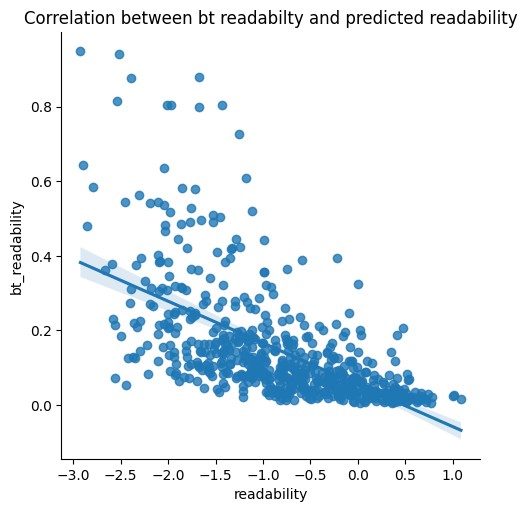

In [84]:
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

print(spearmanr(df_read['readability'], df_read['bt_readability']))

sns.lmplot(df_read, x='readability', y='bt_readability')
plt.title('Correlation between bt readabilty and predicted readability')
plt.savefig("readability_boxplot.png", dpi=300, bbox_inches='tight')

plt.show()


### Findings for the second model
The scatter plot revealed a negative correlation between bt_readability and the model's predicted scores. In this context, higher model scores (which likely indicate more complex or higher-grade-level texts) were associated with lower bt_readability values, consistent with the expected direction of the relationship.

Additionally, the linear regression line shows a clear downward trend, supported by the density of points along that trajectory. This suggests the model is able to distinguish between easier and more complex texts to a much greater extent than the previous model.